# Second model
- Implement some new pipeline functionality. 
- Refactor pre-processing and pipeline code into '../lib'

# TODO - 
- implement a higher power model (https://www.kaggle.com/mineshjethva/exploratory-data-analysis-lightgbm)
- more complex pipeline components. Good example of parallel FeatureUnion
http://scikit-learn.org/stable/auto_examples/hetero_feature_union.html#sphx-glr-auto-examples-hetero-feature-union-py

## Features to engineer
- PCA or other dimensionality reduction on all the housing material features

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [26]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.externals import joblib

In [45]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib.pipeline import f1_scorer, FeatureExtractor, LazyProcessing
from lib.visualization import plot_confusion_matrix

In [5]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

## Important: 
According to the competition (https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403), **ONLY heads of household are used in the scoring**. So we should only fit and evaluate our model on these observations (though in preprocessing we may use all individuals in household-level feature engineering). 
We do, however, need to keep all test data observations for submission. (here is a kernel showing some exploration of discrepancy of labels within households and some individuals without a head of household, but should be irrelevant if we only train on heads https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough)

In [6]:
# from lib.preprocessing import preprocess
# X_train = preprocess(train).drop('Target', axis = 1).query('parentesco1 == 1') #try subsetting to ONLY train on head of household
# X_test = preprocess(test)
# y_train = train.query('parentesco1 == 1')['Target'] #try subsetting to ONLY train on head of household
# X_train[test_features].head()
X_train = train.drop('Target', axis = 1).query('parentesco1 == 1') #try subsetting to ONLY train on head of household
X_test = test.copy()
y_train = train.query('parentesco1 == 1')['Target'] #try subsetting to ONLY train on head of household

In [8]:
test_features = ['meaneduc', 'no_primary_education', 'hh_max_rez_esc_scaled'] + [
    'wall_quality', 'roof_quality', 'floor_quality', 'house_material_vulnerability'] + [
    'house_utility_vulnerability', 'sanitario1', 'pisonotiene', 'cielorazo', 'abastaguano', 'noelec', 'sanitario1'] + [
    'asset_index', 'v18q', 'v18q1', 'refrig', 'computer', 'television'] + [
    'tamviv', 'hogar_nin', 'overcrowding'] + [
    'calc_dependency', 'calc_dependency_bin'] + [
    'phones_pc', 'tablets_pc', 'rooms_pc', 'rent_pc'] + [
    'v2a1', 'v2a1_missing']


In [13]:
# model = Pipeline(steps=[('feature_extraction', FeatureExtractor(test_features)),
#                         ('imputer', Imputer(strategy = 'mean')),
#                 ('random_forest', RandomForestClassifier(random_state = 1))])

model = Pipeline(steps=[('processing', LazyProcessing()),
                        ('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                ('random_forest', RandomForestClassifier(random_state=1))])

kfold = StratifiedKFold(n_splits=5, random_state=1)

In [14]:
DEPTHS = list(range(10,20))
param_grid = dict(random_forest__max_depth=DEPTHS)
grid = GridSearchCV(model, param_grid=param_grid, cv=kfold, scoring=f1_scorer)
grid.fit(X_train, y_train)

# print(grid.cv_results_['mean_test_score'])

best_params = grid.best_params_
print(best_params)

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['rez_esc_scaled'] = df['rez_esc'] / (df['age'] - 6)  # years behind per year (ages 7-17)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A va

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['rez_esc_scaled'] = df['rez_esc'] / (df['age'] - 6)  # years behind per year (ages 7-17)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy 

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['sanitario1'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency'] = (df['hogar_nin'] + df['hogar_mayor']) / df['hogar_adul']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['rez_esc_scaled'] = df['rez_esc'] / (df['age'] - 6)  # years behind per year (ages 7-17)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy 

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['roof_quality'] = 0 * df['etecho1'] + 1 * df['etecho2'] + 2 * df['etecho3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency'] = (df['hogar_nin'] + df['hogar_mayor']) / df['hogar_adul']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency_bin'] = np.where(df['calc_dependency'] == 0, 0, 1)
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['rez_esc_scaled'] = df['rez_esc'] / (df['age'] - 6)  # years behind per year (ages 7-17)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A va

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['rez_esc_scaled'] = df['rez_esc'] / (df['age'] - 6)  # years behind per year (ages 7-17)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy 

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency'] = (df['hogar_nin'] + df['hogar_mayor']) / df['hogar_adul']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency_bin'] = np.where(df['calc_dependency'] == 0, 0, 1)
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['rez_esc_scaled'] = df['rez_esc'] / (df['age'] - 6)  # years behind per year (ages 7-17)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A va

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['roof_quality'] = 0 * df['etecho1'] + 1 * df['etecho2'] + 2 * df['etecho3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency'] = (df['hogar_nin'] + df['hogar_mayor']) / df['hogar_adul']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency_bin'] = np.where(df['calc_dependency'] == 0, 0, 1)
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency'] = (df['hogar_nin'] + df['hogar_mayor']) / df['hogar_adul']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency_bin'] = np.where(df['calc_dependency'] == 0, 0, 1)
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency_bin'] = np.where(df['calc_dependency'] == 0, 0, 1)
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['rez_esc_scaled'] = df['rez_esc'] / (df['age'] - 6)  # years behind per year (ages 7-17)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy 

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency_bin'] = np.where(df['calc_dependency'] == 0, 0, 1)
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['floor_quality'] = 0 * df['eviv1'] + 1 * df['eviv2'] + 2 * df['eviv3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['house_material_vulnerability'] = df['epared1'] + df['etecho1'] + df['eviv1']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['rez_esc_scaled'] = df['rez_esc'] / (df['age'] - 6)  # years behind per year (ages 7-17)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy 

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency_bin'] = np.where(df['calc_dependency'] == 0, 0, 1)
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency_bin'] = np.where(df['calc_dependency'] == 0, 0, 1)
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['tablets_pc'] = df['v18q1'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['sanitario1'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency'] = (df['hogar_nin'] + df['hogar_mayor']) / df['hogar_adul']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['roof_quality'] = 0 * df['etecho1'] + 1 * df['etecho2'] + 2 * df['etecho3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['sanitario1'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency'] = (df['hogar_nin'] + df['hogar_mayor']) / df['hogar_adul']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency_bin'] = np.where(df['calc_dependency'] == 0, 0, 1)
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['rez_esc_scaled'] = df['rez_esc'] / (df['age'] - 6)  # years behind per year (ages 7-17)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy 

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['sanitario1'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency'] = (df['hogar_nin'] + df['hogar_mayor']) / df['hogar_adul']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency_bin'] = np.where(df['calc_dependency'] == 0, 0, 1)
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['roof_quality'] = 0 * df['etecho1'] + 1 * df['etecho2'] + 2 * df['etecho3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['sanitario1'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency'] = (df['hogar_nin'] + df['hogar_mayor']) / df['hogar_adul']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency'] = (df['hogar_nin'] + df['hogar_mayor']) / df['hogar_adul']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency_bin'] = np.where(df['calc_dependency'] == 0, 0, 1)
c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is

{'random_forest__max_depth': 18}


In [ ]:
# clf = lgb.LGBMClassifier(max_depth=-1, learning_rate=0.1, objective='multiclass',
#                              random_state=None, silent=True, metric='None', 
#                              n_jobs=4, n_estimators=5000, class_weight='balanced',
#                              colsample_bytree =  0.89, min_child_samples = 30, num_leaves = 32, subsample = 0.96)

In [16]:
DEPTH = best_params['random_forest__max_depth']

model = Pipeline(steps=[('processing', LazyProcessing()),
                        ('feature_extraction', FeatureExtractor(test_features)),
                        ('imputer', Imputer(strategy = 'mean')),
                        ('feature_scaler', StandardScaler()),
                ('random_forest', RandomForestClassifier(random_state=1, max_depth=DEPTH))])

model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('processing', LazyProcessing()), ('feature_extraction', FeatureExtractor(cols=['meaneduc', 'no_primary_education', 'hh_max_rez_esc_scaled', 'wall_quality', 'roof_quality', 'floor_quality', 'house_material_vulnerability', 'house_utility_vulnerability', 'sanitario1', 'pisonotiene', 'cielorazo'...estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False))])

In [17]:
%%time
cv_score = cross_val_score(model, X_train, y_train, cv = kfold, scoring = f1_scorer)
print(cv_score.mean())
print(f'5 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['roof_quality'] = 0 * df['etecho1'] + 1 * df['etecho2'] + 2 * df['etecho3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['no_primary_education'] = df['instlevel1'] + df['instlevel2']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

0.3573895987952807
5 Fold Cross Validation F1 Score = 0.3574 with std = 0.0203
Wall time: 11.5 s


C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [18]:
print(f'5 Fold Cross Validation F1 Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

5 Fold Cross Validation F1 Score = 0.3574 with std = 0.0203


In [19]:
estimator = model.steps[-1][1]
feature_importances = pd.DataFrame({'feature': test_features, 'importance': estimator.feature_importances_})
feature_importances.sort_values('importance', ascending=False)

,feature,importance
0,meaneduc,0.158047
27,rooms_pc,0.088749
25,phones_pc,0.083189
23,calc_dependency,0.073637
22,overcrowding,0.073264
21,hogar_nin,0.050121
20,tamviv,0.047540
28,rent_pc,0.043531
29,v2a1,0.041479
5,floor_quality,0.038251


# Submission

In [29]:
# Save model for error analysis (other notebook)
joblib.dump(model, '../models/random_forest.pkl')

# model = joblib.load('../models/random_forest.pkl')

['../models/random_forest.pkl']

In [30]:
y_pred = model.predict(X_test)

(array([ 1443.,     0.,     0.,  3615.,     0.,     0.,  1618.,     0.,
            0., 17180.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

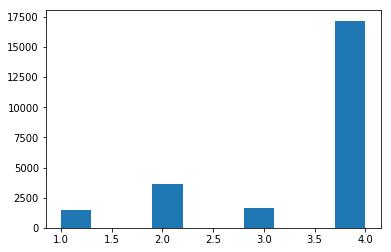

In [21]:
plt.hist(y_pred)

In [22]:
y_pred_series = pd.Series(y_pred, name = 'Target')
submission = pd.concat([X_test['Id'], y_pred_series], axis=1)

In [23]:
submission.to_csv('../submission.csv', index=None)

In [24]:
submission.head()

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


## Error Analysis

In [33]:
y_train_predict = cross_val_predict(model, X_train, y_train, cv = kfold)

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\kaggle\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency_bin'] = np.where(df['calc_dependency'] == 0, 0, 1)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['roof_quality'] = 0 * df['etecho1'] + 1 * df['etecho2'] + 2 * df['etecho3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency_bin'] = np.where(df['calc_dependency'] == 0, 0, 1)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['hh_max_rez_esc_scaled'] = df.groupby('idhogar')['rez_esc_scaled'].transform(lambda x: x.max())
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['phones_pc'] = df['qmobilephone'] / df['tamviv']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['television'])
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['wall_quality'] = 0 * df['epared1'] + 1 * df['epared2'] + 2 * df['epared3']
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['calc_dependency_bin'] = np.where(df['calc_dependency'] == 0, 0, 1)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['v2a1_missing'] = np.where(df['v2a1'].isnull(), 1, 0)
C:\Users\zrankin\Documents\github\poverty_prediction\lib\preprocessing.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


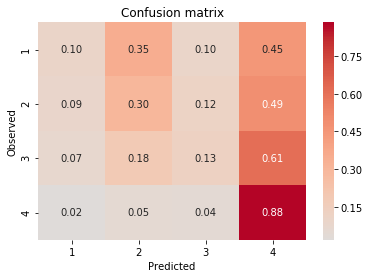

In [55]:
plot_confusion_matrix(y_train, y_train_predict, xticklabels = [1,2,3,4], yticklabels=[1,2,3,4])